Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None

Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None

Users Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   U

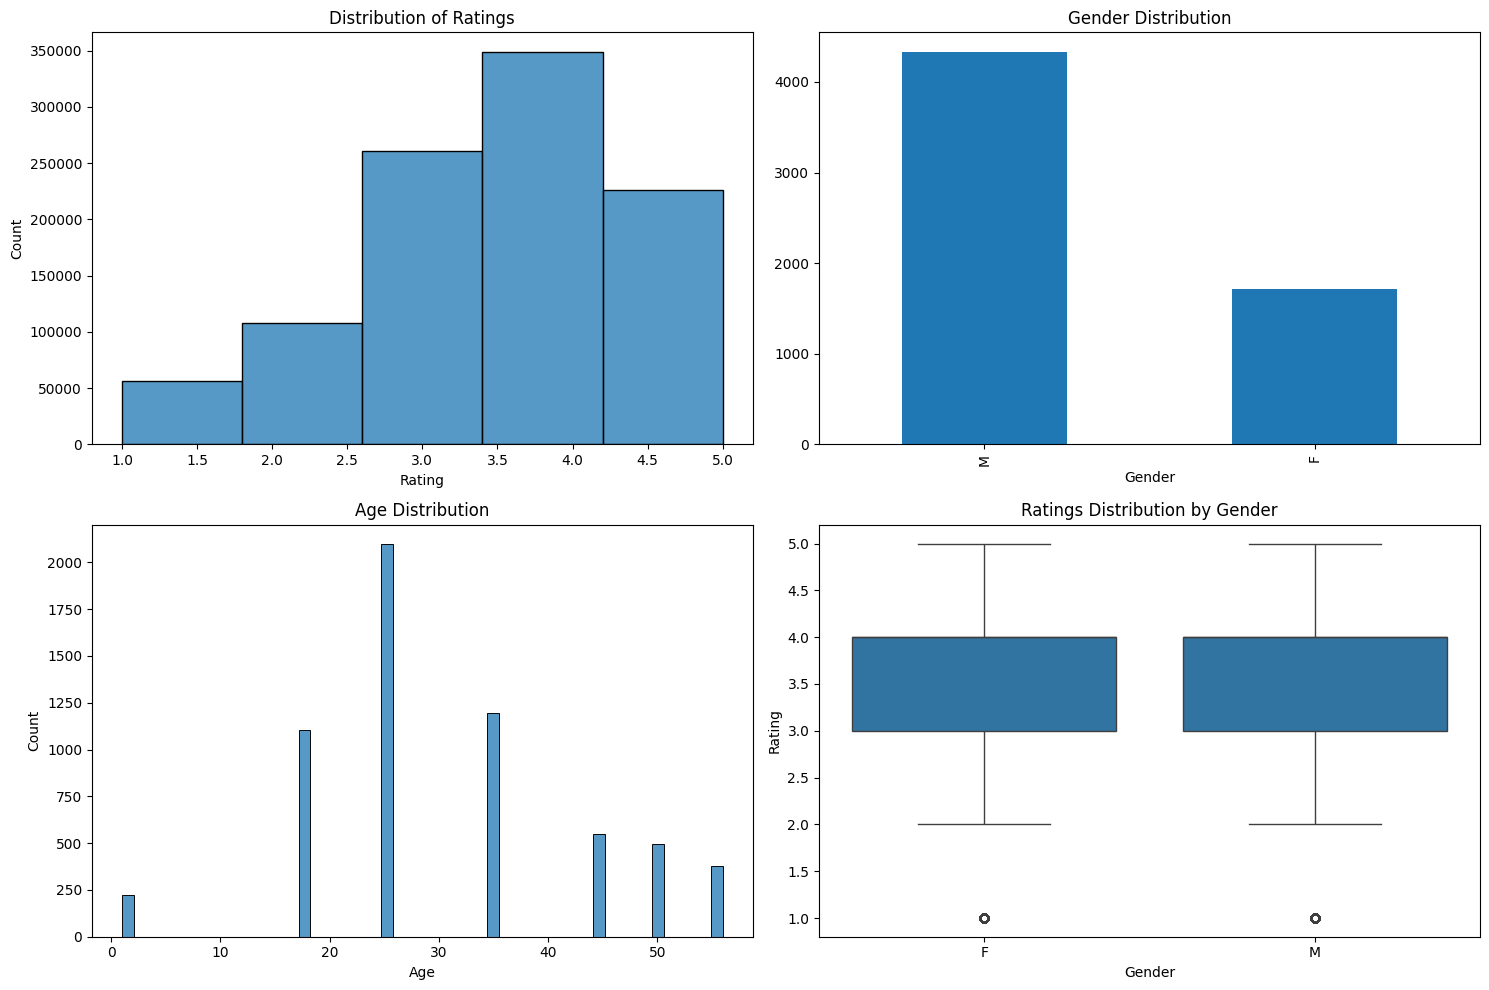

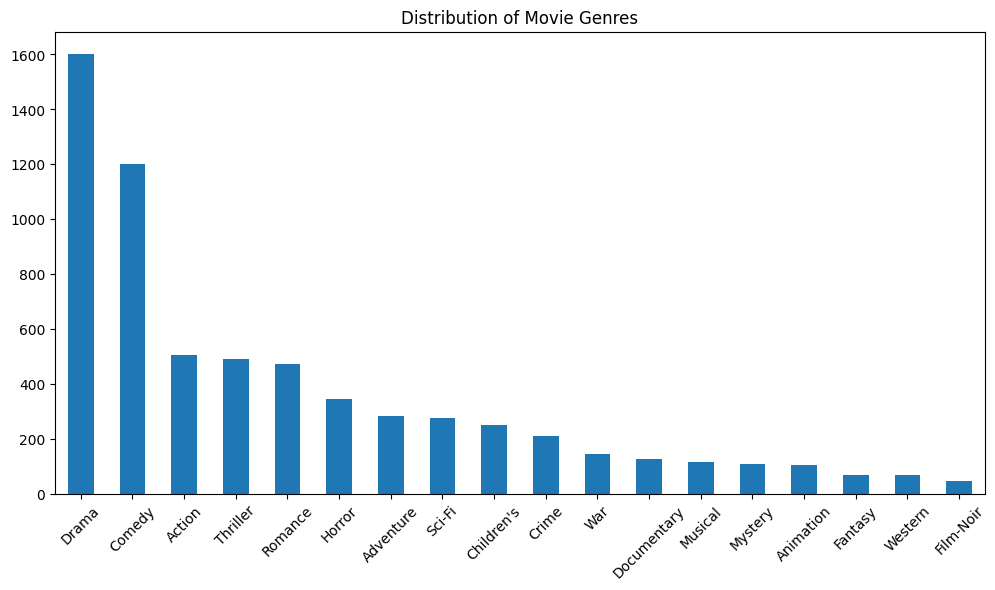

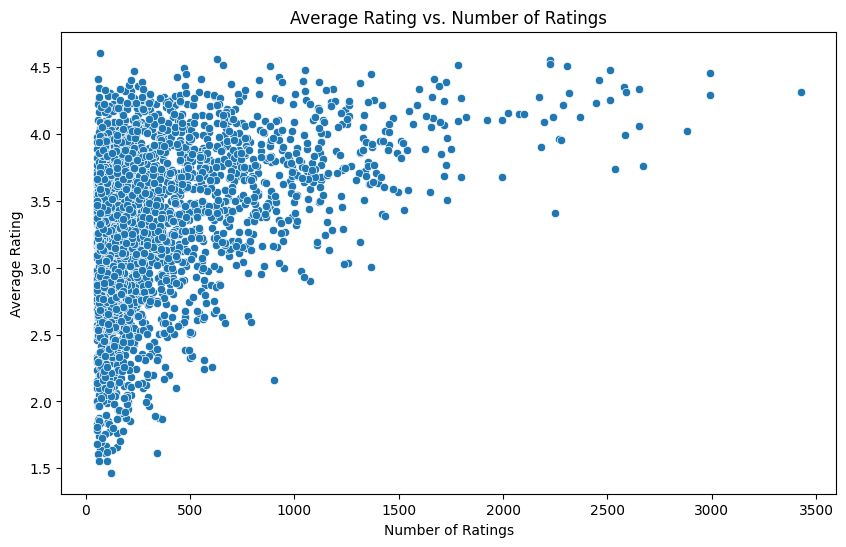

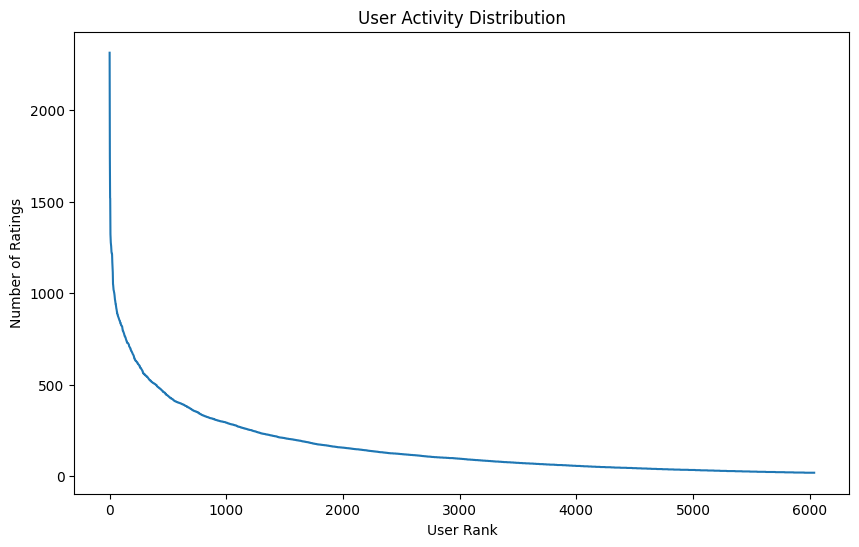

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

# Mount Google Drive
#drive.mount('/content/drive')

# Set the path to your MovieLens folder
movielens_folder = '/content/drive/My Drive/movielens'

movies_df = pd.read_csv('movies.dat', sep='::', engine='python', encoding='latin-1', names=['MovieID', 'Title', 'Genres'])
ratings_df = pd.read_csv('ratings.dat', sep='::', engine='python', encoding='latin-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users_df = pd.read_csv('users.dat', sep='::', engine='python', encoding='latin-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

print("Movies Dataset Info:")
print(movies_df.info())
print("\nRatings Dataset Info:")
print(ratings_df.info())
print("\nUsers Dataset Info:")
print(users_df.info())

print("\nRatings Summary Statistics:")
print(ratings_df['Rating'].describe())

print("\nMissing Values:")
print("Movies:", movies_df.isnull().sum().sum())
print("Ratings:", ratings_df.isnull().sum().sum())
print("Users:", users_df.isnull().sum().sum())

#visualizations
plt.figure(figsize=(15, 10))

#rating Distribution
plt.subplot(2, 2, 1)
sns.histplot(ratings_df['Rating'], bins=5)
plt.title('Distribution of Ratings')

#gender Distribution
plt.subplot(2, 2, 2)
users_df['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')

#age Distribution
plt.subplot(2, 2, 3)
sns.histplot(users_df['Age'])
plt.title('Age Distribution')

#average Rating by Gender
avg_rating_by_gender = pd.merge(ratings_df, users_df, on='UserID')
plt.subplot(2, 2, 4)
sns.boxplot(x='Gender', y='Rating', data=avg_rating_by_gender)
plt.title('Ratings Distribution by Gender')

plt.tight_layout()
plt.show()

#genre Analysis
genres = movies_df['Genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genres.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

#average rating per movie
movie_ratings = ratings_df.groupby('MovieID')['Rating'].agg(['mean', 'count']).reset_index()
movie_ratings = movie_ratings[movie_ratings['count'] > 50]  # Consider movies with more than 50 ratings

plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_ratings, x='count', y='mean')
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

#user activity analysis
user_activity = ratings_df.groupby('UserID')['Rating'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(user_activity.values)
plt.title('User Activity Distribution')
plt.xlabel('User Rank')
plt.ylabel('Number of Ratings')
plt.show()

Before handling missing data:

Movies Dataset Missing Values:
MovieID    0
Title      0
Genres     0
dtype: int64

Ratings Dataset Missing Values:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Users Dataset Missing Values:
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


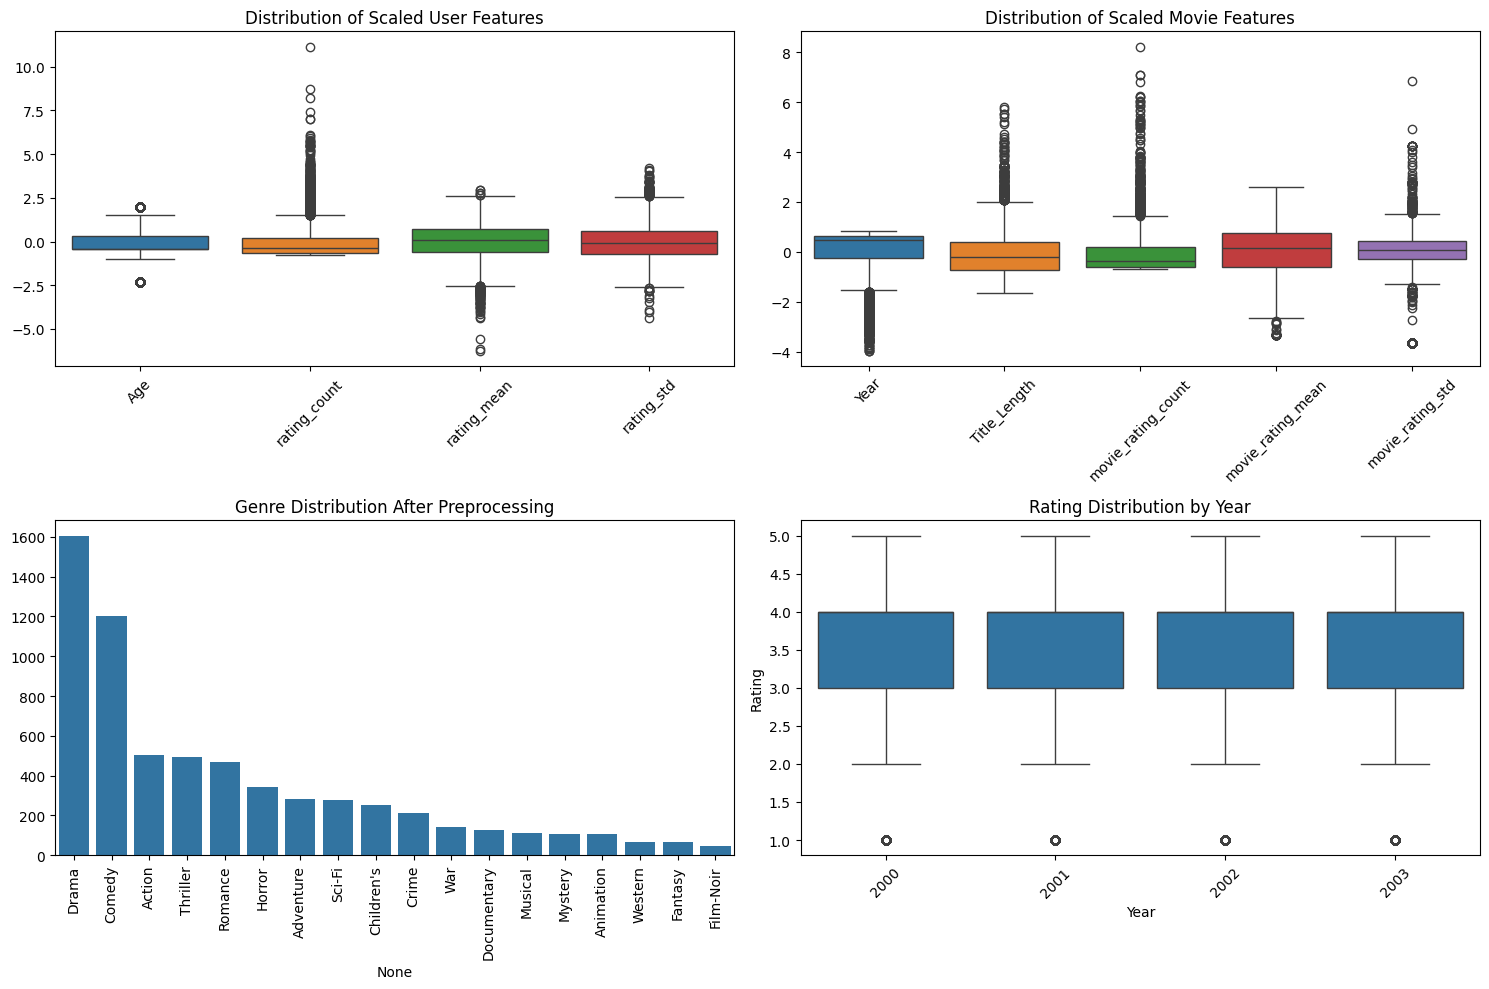


After preprocessing:
Users dataset shape: (6040, 8)
Movies dataset shape: (3883, 26)
Ratings dataset shape: (1000209, 9)


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#missing Data
print("Before handling missing data:")
print("\nMovies Dataset Missing Values:")
print(movies_df.isnull().sum())
print("\nRatings Dataset Missing Values:")
print(ratings_df.isnull().sum())
print("\nUsers Dataset Missing Values:")
print(users_df.isnull().sum())

#fill missing values if any
movies_df = movies_df.fillna({'Genres': 'Unknown'})
ratings_df = ratings_df.dropna()  #frop ratings with missing values

#fill missing values if any
movies_df = movies_df.fillna({'Genres': 'Unknown'})
ratings_df = ratings_df.dropna()  #drop ratings with missing values

#for users dataset, use mode for categorical variables and median for numerical
users_df['Gender'] = users_df['Gender'].fillna(users_df['Gender'].mode()[0])
users_df['Age'] = users_df['Age'].fillna(users_df['Age'].median())
users_df['Occupation'] = users_df['Occupation'].fillna(users_df['Occupation'].mode()[0])
users_df['Zip-code'] = users_df['Zip-code'].fillna(users_df['Zip-code'].mode()[0])

#Feature Engineering
# process Timestamp
ratings_df['DateTime'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')
ratings_df['Year'] = ratings_df['DateTime'].dt.year
ratings_df['Month'] = ratings_df['DateTime'].dt.month
ratings_df['DayOfWeek'] = ratings_df['DateTime'].dt.dayofweek
ratings_df['Hour'] = ratings_df['DateTime'].dt.hour

#extract year from movie titles
movies_df['Year'] = movies_df['Title'].str.extract('\((\d{4})\)').astype(float)
movies_df['Title_Length'] = movies_df['Title'].str.len()

#create genre features (one-hot encoding)
genre_dummies = movies_df['Genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genre_dummies], axis=1)

#create user features
user_rating_stats = ratings_df.groupby('UserID').agg({
    'Rating': ['count', 'mean', 'std']
}).fillna(0)
user_rating_stats.columns = ['rating_count', 'rating_mean', 'rating_std']
users_df = users_df.merge(user_rating_stats, left_on='UserID', right_index=True, how='left')

#create movie features
movie_rating_stats = ratings_df.groupby('MovieID').agg({
    'Rating': ['count', 'mean', 'std']
}).fillna(0)
movie_rating_stats.columns = ['movie_rating_count', 'movie_rating_mean', 'movie_rating_std']
movies_df = movies_df.merge(movie_rating_stats, left_on='MovieID', right_index=True, how='left')

#Encoding Categorical Variables
#gender encoding
users_df['Gender'] = users_df['Gender'].map({'M': 1, 'F': 0})

#create separate dataframes for numerical and categorical features
users_numerical = users_df[['Age', 'rating_count', 'rating_mean', 'rating_std']]
movies_numerical = movies_df[['Year', 'Title_Length', 'movie_rating_count',
                            'movie_rating_mean', 'movie_rating_std']]

#standardization/Normalization
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

#scale user features
users_scaled = pd.DataFrame(
    standard_scaler.fit_transform(users_numerical),
    columns=users_numerical.columns,
    index=users_numerical.index
)

#scale movie features
movies_scaled = pd.DataFrame(
    standard_scaler.fit_transform(movies_numerical),
    columns=movies_numerical.columns,
    index=movies_numerical.index
)

#visualization of preprocessed data
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=users_scaled)
plt.title('Distribution of Scaled User Features')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(data=movies_scaled)
plt.title('Distribution of Scaled Movie Features')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
genre_counts = genre_dummies.sum().sort_values(ascending=False)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Distribution After Preprocessing')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.boxplot(data=ratings_df, x='Year', y='Rating')
plt.title('Rating Distribution by Year')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nAfter preprocessing:")
print(f"Users dataset shape: {users_df.shape}")
print(f"Movies dataset shape: {movies_df.shape}")
print(f"Ratings dataset shape: {ratings_df.shape}")

users_scaled.to_csv('users_preprocessed.csv')
movies_scaled.to_csv('movies_preprocessed.csv')
ratings_df.to_csv('ratings_preprocessed.csv')

# except Exception as e:
#     print(f"An error occurred: {str(e)}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm
import pickle
import heapq
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

def calculate_metrics(true_ratings, predicted_ratings, k=10):
    """Calculate RMSE, MAP@k, and NDCG@k"""
    rmse = np.sqrt(mean_squared_error(true_ratings.flatten(), predicted_ratings.flatten()))

    # Calculate MAP@k
    ap_sum = 0
    num_users = len(true_ratings)

    for i in range(num_users):
        true_items = np.argsort(-true_ratings[i])[:k]
        pred_items = np.argsort(-predicted_ratings[i])[:k]

        ap = 0
        hits = 0

        for j, item in enumerate(pred_items, 1):
            if item in true_items:
                hits += 1
                ap += hits / j

        if len(true_items) > 0:
            ap_sum += ap / min(len(true_items), k)

    map_k = ap_sum / num_users

    # Calculate NDCG@k
    ndcg_sum = 0

    for i in range(num_users):
        true_sorted = -np.sort(-true_ratings[i])[:k]
        ideal_dcg = np.sum(true_sorted / np.log2(np.arange(2, len(true_sorted) + 2)))

        pred_values = predicted_ratings[i][np.argsort(-predicted_ratings[i])[:k]]
        dcg = np.sum(pred_values / np.log2(np.arange(2, len(pred_values) + 2)))

        if ideal_dcg > 0:
            ndcg_sum += dcg / ideal_dcg

    ndcg_k = ndcg_sum / num_users

    return rmse, map_k, ndcg_k

class ContentBasedRecommender:
    def __init__(self):
        self.movie_features = None
        self.movie_similarity = None
        self.movies_df = None

    def fit(self, movies_df):
        self.movies_df = movies_df.copy()
        # Select numeric columns for features
        feature_columns = movies_df.select_dtypes(include=['int64', 'float64', 'uint8', 'bool']).columns
        exclude_columns = ['MovieID', 'Year']
        feature_columns = [col for col in feature_columns if col not in exclude_columns]

        if len(feature_columns) == 0:
            raise ValueError("No valid feature columns found in the movies dataframe")

        print(f"Using features: {feature_columns}")

        # Handle missing values
        self.movie_features = movies_df[feature_columns].fillna(0).values

        print(f"Feature matrix shape: {self.movie_features.shape}")

        # Calculate similarity matrix
        self.movie_similarity = cosine_similarity(self.movie_features)

        return self

    def predict(self, user_ratings, movie_indices):
        """
        Predict ratings for given movie indices based on user's rating history.

        Parameters:
        -----------
        user_ratings : numpy array
            Array of user ratings (with zeros for unrated items)
        movie_indices : array-like
            Indices of movies to predict ratings for

        Returns:
        --------
        numpy array
            Predicted ratings for the given movie indices
        """
        # Initialize predictions array
        predictions = np.zeros(len(movie_indices))

        # Find movies that the user has rated (non-zero ratings)
        rated_items = np.where(user_ratings > 0)[0]

        if len(rated_items) > 0:  # If the user has rated any movies
            for i, movie_idx in enumerate(movie_indices):
                if movie_idx < self.movie_similarity.shape[0]:  # Check if movie index is valid
                    # Get similarity scores for current movie
                    sim_scores = self.movie_similarity[movie_idx]

                    # Calculate weighted rating based on similarities
                    weighted_sum = np.sum(sim_scores[rated_items] * user_ratings[rated_items])
                    similarity_sum = np.sum(np.abs(sim_scores[rated_items]))

                    if similarity_sum > 0:
                        predictions[i] = weighted_sum / similarity_sum
                    else:
                        # If no similar items found, use mean of user's ratings
                        predictions[i] = np.mean(user_ratings[rated_items])

        # Clip predictions to valid rating range (assuming 1-5 rating scale)
        predictions = np.clip(predictions, 1, 5)

        return predictions

    def predict_all(self, ratings_matrix):
        """
        Predict all missing ratings in the ratings matrix.

        Parameters:
        -----------
        ratings_matrix : numpy array
            Matrix of user-item ratings

        Returns:
        --------
        numpy array
            Matrix with predicted ratings for all missing values
        """
        predictions = np.zeros_like(ratings_matrix)

        for i in tqdm(range(len(ratings_matrix)), desc="Generating CB predictions"):
            predictions[i] = self.predict(ratings_matrix[i], range(ratings_matrix.shape[1]))

        return predictions

class CollaborativeFiltering:
    def __init__(self):
        self.user_similarity = None
        self.mean_ratings = None

    def fit(self, ratings_matrix):
        # Calculate mean ratings and handle nan values
        self.mean_ratings = np.nanmean(ratings_matrix, axis=1).reshape(-1, 1)
        self.mean_ratings = np.nan_to_num(self.mean_ratings, 0)

        # Normalize ratings by subtracting mean
        normalized_ratings = ratings_matrix - self.mean_ratings
        normalized_ratings = np.nan_to_num(normalized_ratings, 0)

        # Calculate user similarity
        self.user_similarity = cosine_similarity(normalized_ratings)
        self.ratings_matrix = ratings_matrix
        return self

    def predict(self, ratings_matrix, k=10):
        predictions = np.zeros_like(ratings_matrix)
        n_users, n_items = ratings_matrix.shape

        for i in tqdm(range(n_users), desc="CF Predictions"):
            # Find k most similar users
            similar_user_indices = np.argsort(self.user_similarity[i])[-k-1:-1]
            similar_user_indices = similar_user_indices[similar_user_indices < len(self.mean_ratings)]

            if len(similar_user_indices) == 0:
                predictions[i] = self.mean_ratings[i]
                continue

            for j in range(n_items):
                if ratings_matrix[i][j] == 0:  # Only predict unrated items
                    # Get ratings from similar users for this item
                    similar_ratings = self.ratings_matrix[similar_user_indices, j]
                    similar_means = self.mean_ratings[similar_user_indices]
                    similar_weights = self.user_similarity[i][similar_user_indices]

                    # Calculate weighted average
                    numerator = np.sum(similar_weights * (similar_ratings - similar_means.flatten()))
                    denominator = np.sum(np.abs(similar_weights)) + 1e-8  # Add small epsilon to avoid division by zero

                    # Make prediction
                    pred = self.mean_ratings[i] + (numerator / denominator)
                    predictions[i][j] = np.clip(pred, 1, 5)  # Clip predictions to valid rating range
                else:
                    predictions[i][j] = ratings_matrix[i][j]

        return predictions

class MatrixFactorization:
    def __init__(self, n_factors=100):
        self.n_factors = n_factors
        self.user_factors = None
        self.movie_factors = None

    def fit(self, ratings_matrix):
        # Perform SVD
        U, sigma, Vt = svds(ratings_matrix, k=self.n_factors)
        self.user_factors = U
        self.movie_factors = Vt.T
        self.sigma = sigma
        return self

    def predict(self, ratings_matrix):
        return np.dot(np.dot(self.user_factors, np.diag(self.sigma)), self.movie_factors.T)

class HybridRecommender:
    def __init__(self, cb_weight=0.3, cf_weight=0.3, mf_weight=0.4):
        self.cb_weight = cb_weight
        self.cf_weight = cf_weight
        self.mf_weight = mf_weight
        self.cb_model = ContentBasedRecommender()
        self.cf_model = CollaborativeFiltering()
        self.mf_model = MatrixFactorization()

    def fit(self, ratings_matrix, movies_df):
        print("Training Content-Based Model...")
        self.cb_model.fit(movies_df)

        print("Training Collaborative Filtering Model...")
        self.cf_model.fit(ratings_matrix)

        print("Training Matrix Factorization Model...")
        self.mf_model.fit(ratings_matrix)

        return self

    def predict(self, ratings_matrix, movies_df):
        print("Generating predictions...")
        cb_pred = np.zeros_like(ratings_matrix)
        for i in tqdm(range(len(ratings_matrix)), desc="CB Predictions"):
            cb_pred[i] = self.cb_model.predict(ratings_matrix[i], range(ratings_matrix.shape[1]))

        cf_pred = self.cf_model.predict(ratings_matrix)
        mf_pred = self.mf_model.predict(ratings_matrix)

        # Combine predictions
        predictions = (
            self.cb_weight * cb_pred +
            self.cf_weight * cf_pred +
            self.mf_weight * mf_pred
        )

        return predictions

def evaluate_model(model_name, predictions, test_ratings, runtime):
    rmse, map_10, ndcg_10 = calculate_metrics(test_ratings, predictions)
    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAP@10: {map_10:.4f}")
    print(f"NDCG@10: {ndcg_10:.4f}")
    print(f"Runtime: {runtime:.2f} seconds")
    return rmse, map_10, ndcg_10, runtime

def main():
    # Load preprocessed data
    users_scaled = pd.read_csv('users_preprocessed.csv')
    movies_scaled = pd.read_csv('movies_preprocessed.csv')
    ratings_df = pd.read_csv('ratings_preprocessed.csv')

    # Create ratings matrix
    ratings_matrix = ratings_df.pivot(
        index='UserID',
        columns='MovieID',
        values='Rating'
    ).fillna(0).values

    # Split data
    train_matrix, test_matrix = train_test_split(
        ratings_matrix,
        test_size=0.2,
        random_state=42
    )

    results = []

    # Content-Based Filtering
    start_time = time.time()
    cb_model = ContentBasedRecommender()
    cb_model.fit(movies_scaled)
    cb_pred = cb_model.predict_all(test_matrix)  # Use predict_all instead of loop
    for i in tqdm(range(len(test_matrix)), desc="CB Predictions"):
        cb_pred[i] = cb_model.predict(test_matrix[i], range(test_matrix.shape[1]))
    cb_runtime = time.time() - start_time
    results.append(evaluate_model("Content-Based Filtering", cb_pred, test_matrix, cb_runtime))

    # Collaborative Filtering
    start_time = time.time()
    cf_model = CollaborativeFiltering()
    cf_model.fit(train_matrix)
    cf_pred = cf_model.predict(test_matrix)
    cf_runtime = time.time() - start_time
    results.append(evaluate_model("Collaborative Filtering", cf_pred, test_matrix, cf_runtime))

    # Matrix Factorization
    start_time = time.time()
    mf_model = CollaborativeFiltering()
    mf_model.fit(train_matrix)
    mf_pred = cf_model.predict(test_matrix)
    mf_runtime = time.time() - start_time
    results.append(evaluate_model("Matrix Factorization", mf_pred, test_matrix, mf_runtime))

    # Hybrid Approach
    start_time = time.time()
    hybrid_model = HybridRecommender()
    hybrid_model.fit(train_matrix, movies_scaled)
    hybrid_pred = hybrid_model.predict(test_matrix, movies_scaled)
    hybrid_runtime = time.time() - start_time
    results.append(evaluate_model("Hybrid Approach", hybrid_pred, test_matrix, hybrid_runtime))

    # Save models
    models = {
        'content_based': cb_model,
        'collaborative': cf_model,
        'matrix_factorization': mf_model,
        'hybrid': hybrid_model
    }

    for name, model in models.items():
        with open(f'{name}_model.pkl', 'wb') as f:
            pickle.dump(model, f)

    # Visualize results
    methods = ['Content-Based', 'Collaborative', 'Matrix Factorization', 'Hybrid']
    metrics = ['RMSE', 'MAP@10', 'NDCG@10', 'Runtime']

    results_df = pd.DataFrame(results, columns=metrics, index=methods)

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 4, i+1)
        results_df[metric].plot(kind='bar')
        plt.title(metric)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Using features: ['Unnamed: 0', 'Title_Length', 'movie_rating_count', 'movie_rating_mean', 'movie_rating_std']
Feature matrix shape: (3883, 5)


CB Predictions: 100%|██████████| 1208/1208 [00:42<00:00, 28.25it/s]



Content-Based Filtering Results:
RMSE: 3.6506
MAP@10: 0.0126
NDCG@10: 0.7540
Runtime: 85.61 seconds


CF Predictions: 100%|██████████| 1208/1208 [01:23<00:00, 14.54it/s]



Collaborative Filtering Results:
RMSE: 1.0852
MAP@10: 0.3980
NDCG@10: 1.0065
Runtime: 83.90 seconds


CF Predictions: 100%|██████████| 1208/1208 [01:23<00:00, 14.54it/s]



Matrix Factorization Results:
RMSE: 1.0852
MAP@10: 0.3980
NDCG@10: 1.0065
Runtime: 83.86 seconds
Training Content-Based Model...
Using features: ['Unnamed: 0', 'Title_Length', 'movie_rating_count', 'movie_rating_mean', 'movie_rating_std']
Feature matrix shape: (3883, 5)
Training Collaborative Filtering Model...
Training Matrix Factorization Model...
Generating predictions...


CF Predictions:  52%|█████▏    | 634/1208 [00:44<00:40, 14.16it/s]